# Network Analysis Project 
#### Building an Recommendation System from Bipartite Networks
---

*Ludek Cizinský (luci@itu.dk)*, *Louis Brandt (locb@itu.dk)*, *Lukas Rasocha (lukr@itu.dk)*, *Mika Senghaas (jsen@itu.dk)*, *Jacob Victor Enggaard Haahr (javh@itu.dk)*

Course Manager: *Michele Coscia*

Deadline: *22nd Decemeber 2021*

Last Modified: *28th September 2021*

## Assignment Description
---
You will have to deliver your project at the end of the course (deadline to be determined). You have to hand in a presentation (in PDF or Power Point format). It is mandatory to include the following information:

- Basic network description of your data (what type of network it is, what does it represent, is it real or synthetically generated, etc). In practice, the result of project phase #1 (finding data).
- Basic network statistics of your data (number of nodes, edges, clustering, degree distribution, etc). In practice, the result of project phase #2 (exploratory data analysis).
- A clear statement of your research question, the result of project phase #3.
- The analysis, results, and interpretation that allow you to answer your research question, the result of project phase #4.

You're free to include this in the order you prefer and to add any additional information you deem necessary, but these are the mandatory components.

The format of the oral is as follows: the students make a joint presentation followed by group questions. Subsequently the students are having individual examination with additional questions while the rest of the group is outside the room. The length of the oral will be 15 minutes X number of group members plus one -- for instance, a group of 6 will have 105 minutes ((6+1)*15). Which means you have 15 minutes of group exam plus 15 minutes of individual exam each.

## Environment Setup
---
This project uses Python libraries that are essential for the performed analysis. Make sure to have the dependencies listed in `requirements.txt` installed locally using the *Python Package Manager* `pip`. If installed, running the next code cell should install all relevant dependencies. Check documentation via the provided links:

- [*NetworkX* Documentation](https://networkx.org/documentation/stable/reference/index.html)

- [*NumPy* Quickstart](https://numpy.org/doc/stable/user/quickstart.html)
- [*Matplotlib* Documentation](https://matplotlib.org/stable/tutorials/introductory/usage.html)
- [*Pandas* Documentation](https://pandas.pydata.org/docs/)

### Libraries

In [ ]:
%%capture
!pip install -r requirements.txt

In [ ]:
# network representation and algorithms
import networkx as nx
from networkx.algorithms import bipartite
from pyvis.network import Network
from networkx import linalg as nxla


from matplotlib import pyplot as plt           # basic plotting
import seaborn as sns                          # advanced plotting
import numpy as np                             # for representing n-dimensional arrays
import scipy as sp                             # numerical computation
import pandas as pd                            # dataframes
from sklearn.linear_model import LinearRegression # Power fit



# python standard library
import json                                    # read/ write json
import re                                      # regex search 
import os                                      # os operations
import random                                  # randomness

### Flags

Flags are used to control the run flow of the notebook when executed at once. This is useful, to prevent operations that should only produce a result once, from running multiple times. 

In [ ]:
# section flags
LOAD_DATA = True
TRANSFORM_DATA = False
COMPUTE_PROJECTIONS = False

### Constants



In [ ]:
PATH_TO = {}
PATH_TO['data'] = {}
PATH_TO['data']['raw'] = 'data/raw'
PATH_TO['data']['transformed'] = 'data/transformed'
PATH_TO['data']['projections'] = 'data/projections'

### Folder Structure

Create relevant folders to read from and write to, if not yet existent.

In [ ]:
# iterate over path_to dict
DIRS = ['data/raw', 'data/transformed', 'visualisations', '']
# what folders do we need (?)
for dir in DIRS:
    # create if not existent
    pass

## #01 Loading and Inspecting Raw Data
---

In [ ]:
if LOAD_DATA:
    data = pd.read_csv(f"{PATH_TO['data']['raw']}/data.txt", delimiter=":", names=["user_id", "repo_id"])
    repos = pd.read_csv(f"{PATH_TO['data']['raw']}/repos.txt", delimiter=":", names=["repo_id", "meta_info"])
    lang = pd.read_csv(f"{PATH_TO['data']['raw']}/lang.txt", delimiter=":", names=["repo_id", "meta_info"])

### `data.txt`

This is the main dataset.  Each line is of the format `<user_id>`:`<repo_id>`
which represents a user watching a repository.  There are 440,237 records
in this file, each a single `user_id` and a single `repository_id` seperated by a colon. This file, thus, represents the bipartite graph of users following repositories as an edge list. The data looks like this:

In [ ]:
print(f"Size of data.txt: {data.shape}")
print(f"Number of Unique Users: {len(np.unique(data['user_id']))}")
print(f"Number of Unique Repos: {len(np.unique(data['repo_id']))}")

data.head()

Size of data.txt: (440237, 2)
Number of Unique Users: 56519
Number of Unique Repos: 120867


,user_id,repo_id
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5


### `repos.txt`

This file lists out the 120,867 unique repositories using their id (`repo_id`) that are used in the `data.txt`
set, providing the repository name, date it was created and (if applicable)
the repository id that it was forked off of.  The data looks like this:

In [ ]:
print(f"Size of repo.txt: {repos.shape}")
print(f"ID's of data.txt and repos.txt match: {sum(np.unique(data['repo_id']) == np.unique(repos['repo_id'])) == 120867}")
print(f"No. of Repos with forking info: {sum(repos['meta_info'].apply(lambda x: len(x.split(','))) == 3)}")

repos.head()

Size of repo.txt: (120867, 2)
ID's of data.txt and repos.txt match: True
No. of Repos with forking info: 38954


,repo_id,meta_info
0,1,"richardc/perl-number-compare,2009-02-26"
1,2,"axiomsoftware/axiom-inspector,2009-05-09"
2,3,"rails/open_id_authentication,2008-05-29"
3,4,"brandonkelly/bk.fieldframe.ee_addon,2009-01-31"
4,5,"skinofstars/boxfire,2009-01-31"


### `lang.txt`

The last dataset included is the language breakdown data.  This lists  only contains 73,496 repositories, for which the language data was available. Each line of this file lists the repository id, then a comma delimited list of 
`<lang>`;`<lines>` entries containing each major language found and the number
of lines of code for that language in the project.  The data looks like this:

In [ ]:
print(f"Size of repo.txt: {lang.shape}")

lang.head()

Size of repo.txt: (73496, 2)


,repo_id,meta_info
0,8213,"JavaScript;802,Ruby;395056"
1,24640,"Shell;173,Java;2580,Groovy;26623,JavaScript;13..."
2,41067,Ruby;52570
3,82135,Ruby;175049
4,16427,Perl;15008


## #02 Transforming Data
---

###  Adding Class to Nodes in Edge List 

In the edge list `data.txt` the edges connecting a node of type *User* (from now referred to as $U$) to a node of type *Repository* (from now referred to as $R$) cannot be differentiated on each row. To read in the graph object correctly at a later point, we therefore add correct labeling into that dataframef 

In [ ]:
if TRANSFORM_DATA:
    data["user_id"] = data["user_id"].apply(lambda x: "u" + str(x))
    data["repo_id"] = data["repo_id"].apply(lambda x: "r" + str(x))

### Create Metadata

In [ ]:
if TRANSFORM_DATA:
    # save repo metadata in dictionary
    metadata = {}

    # save metadata from repos.txt
    for i in range(len(repos)):
        repo_id, meta_info = repos.iloc[i]

        # parse the meta info
        if len(meta_info.split(',')) == 2:
            repo_name, creation_date, forked_from_id = meta_info.split(',') + [None]
        else:
            # you had None here at index 2 as well (not intended?)
            repo_name, creation_date, forked_from_id = meta_info.split(',')

        # save to dict
        metadata[f"r{repo_id}"] = {
            "repo_name": repo_name,
            "creation_date": creation_date,
            "forked_from_id": forked_from_id
        }
    
    # sve metadata from lang.txt
    for i in range(len(lang)):
        repo_id, lang_info = lang.iloc[i]
       
        # save it
        if f"r{repo_id}" in metadata.keys():
            metadata[f"r{repo_id}"]["languages"] = [l.split(';') for l in lang_info.split(',')]

Got this error when not checking if key in metadata dict, `KeyError: 'r59337'`. Kinda throws me off, since the metadata keys are initialised by iterating over repos.txt, which should contain all unique repos. that must mean that only is the lang not complete, but also contains records about repos that we don't have in our network data

### Save Transformed Files

For faster access later, the following code cell saves the transformed network data and meta data into the directory `data/transformed`. 

In [ ]:
if TRANSFORM_DATA:
    # save edge list
    data.to_csv(f"{PATH_TO['data']['transformed']}/data.txt", header=False, index=False)

    # save metadata as json
    with open(f"{PATH_TO['data']['transformed']}/metadata.json", "w") as fp:
        json.dump(metadata, fp)

## #03 Load Graph 

After having transformed the raw data in a format that is easily usable to be loaded as a graph object, we load our graph. We are using `networkX` - the standard library in Python for representation, visualisation and computation on graphs. 

In [ ]:
# load graph
G = nx.read_edgelist(f"{PATH_TO['data']['transformed']}/data.txt", delimiter=",", comments='#', create_using=nx.Graph)

In [ ]:
# load metadata
with open(f"{PATH_TO['data']['transformed']}/metadata.json", "r") as fp:
    metadata = json.load(fp)

# add metadata to graph nodes
for repo_id, vals in metadata.items():
    to_add = {repo_id: vals}
    nx.set_node_attributes(G, to_add, "metadata")

In [ ]:
# Show a random node's attributes
G.nodes["r2"]["metadata"]

{'repo_name': 'axiomsoftware/axiom-inspector',
 'creation_date': '2009-05-09',
 'forked_from_id': None,
 'languages': [['JavaScript', '2940890']]}

## #04 Basic Network Statistics

### Numerical Summary

In [ ]:
# Store fundamental properties within pandas DF
overview = pd.DataFrame(columns=["name", "is_bipartite", "is_directed", "is_weighted", "has_negative_weights", "selfloops_#", "nodes_#", "edges_#", "density"])

In [ ]:
# save important data to dict
G_info = dict()

# fundamental stats
G_info["name"] = "Github contest 2009"
G_info["number_of_users"] = len([node for node in G.nodes() if node[0] == 'u'])
G_info["number_of_repos"] = len([node for node in G.nodes() if node[0] == 'r'])
G_info["repo_highest_deg"] = max([len(list(nx.classes.function.neighbors(G, node))) for node in G.nodes() if node[0] == 'r'])
G_info["repo_highest_deg_name"] = G.nodes[[node for node in G.nodes() if node[0] == 'r' and len(list(nx.classes.function.neighbors(G, node))) == G_info["repo_highest_deg"]][0]]["metadata"]["repo_name"]
G_info["user_highest_deg"] = max([len(list(nx.classes.function.neighbors(G, node))) for node in G.nodes() if node[0] == 'u'])
G_info["is_directed"] = nx.is_directed(G)
G_info["is_weighted"] = nx.is_weighted(G)
G_info["has_negative_weights"] = nx.is_negatively_weighted(G)
G_info["selfloops_#"] = nx.number_of_selfloops(G)
G_info["nodes_#"] = nx.number_of_nodes(G)
G_info["edges_#"] = nx.number_of_edges(G)
G_info["density"] = nx.density(G)
G_info["is_bipartite"] = bool(nx.is_bipartite(G))

# add it do the overview
overview = overview.append(G_info, ignore_index=True)
overview

,name,is_bipartite,is_directed,is_weighted,has_negative_weights,selfloops_#,nodes_#,edges_#,density,number_of_repos,number_of_users,repo_highest_deg,repo_highest_deg_name,user_highest_deg
0,Github contest 2009,True,False,False,False,0,177386,440237,0.000028,120867.0,56519.0,3675.0,rails/rails,884.0


### Top 10 repositories

In [ ]:
repos_degree = sorted([(repo, G.degree(repo)) for repo in G.nodes() if repo[0] == 'r'], key=lambda x: x[1], reverse=True)[:10]
repo_info = {
    "name": [G.nodes[repo_tuple[0]]["metadata"]["repo_name"] for repo_tuple in repos_degree],
    "degree": [repo_tuple[1] for repo_tuple in repos_degree],
    "technology_stack": [G.nodes[repo_tuple[0]]["metadata"]["languages"] for repo_tuple in repos_degree]
}
top_10_repos = pd.DataFrame(repo_info)
top_10_repos

,name,degree,technology_stack
0,rails/rails,3675,"[[JavaScript, 2438], [Ruby, 5423161]]"
1,technoweenie/restful-authentication,1929,"[[Ruby, 140923]]"
2,mislav/will_paginate,1611,"[[Ruby, 90684]]"
3,joshuaclayton/blueprint-css,1565,"[[Ruby, 32998]]"
4,binarylogic/authlogic,1438,"[[Ruby, 236385]]"
5,thoughtbot/paperclip,1362,"[[Ruby, 153462]]"
6,aslakhellesoy/cucumber,1159,"[[C Sharp, 339], [Java, 355], [Ruby, 319537]]"
7,madrobby/scriptaculous,1136,"[[Ruby, 3893], [JavaScript, 40316]]"
8,dchelimsky/rspec,1100,"[[Ruby, 726592]]"
9,technoweenie/attachment_fu,1006,"[[Ruby, 132960]]"


In [ ]:
set(G["u54540"])

{'r115565'}

### Degree distribution

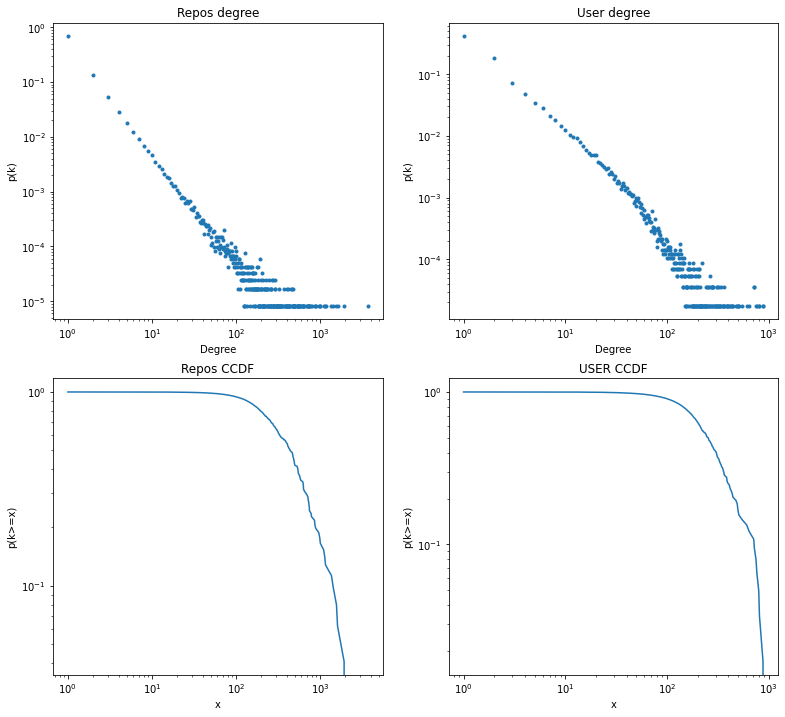

In [ ]:
user_degree = [G.degree(n) for n in G.nodes() if n[0] == 'u']
repos_degree = [G.degree(n) for n in G.nodes() if n[0] == 'r']

user_degree, count_user_degree = np.unique(user_degree, return_counts=True)
repos_degree, count_repos_degree = np.unique(repos_degree, return_counts=True)

#Normalize
count_user_degree = count_user_degree / sum(count_user_degree)
count_repos_degree = count_repos_degree / sum(count_repos_degree)

#CDF
cdf_user_degree = user_degree.cumsum() / np.sum(user_degree)
cdf_repos_degree = repos_degree.cumsum() / np.sum(repos_degree)

#CCDF
ccdf_user_degree = 1-cdf_user_degree
ccdf_repos_degree = 1-cdf_repos_degree

#Plotting on a log-log scale
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 12))
axes[0][0].plot(repos_degree, count_repos_degree,'.')
axes[0][0].set_xlabel('Degree')
axes[0][0].set_title('Repos degree')
axes[0][0].set_ylabel('p(k)')
axes[0][0].set_yscale('log')
axes[0][0].set_xscale('log')


axes[0][1].plot(user_degree, count_user_degree,'.')
axes[0][1].set_title('User degree')
axes[0][1].set_xlabel('Degree')
axes[0][1].set_ylabel('p(k)')
axes[0][1].set_yscale('log')
axes[0][1].set_xscale('log')

#CCDF
#Repos ccdf
axes[1][0].plot(repos_degree,ccdf_repos_degree)
axes[1][0].set_title('Repos CCDF')
axes[1][0].set_xlabel('x')
axes[1][0].set_ylabel('p(k>=x)')
axes[1][0].set_yscale('log')
axes[1][0].set_xscale('log')

#User ccdf
axes[1][1].plot(user_degree,ccdf_user_degree)
axes[1][1].set_title('USER CCDF')
axes[1][1].set_xlabel('x')
axes[1][1].set_ylabel('p(k>=x)')
axes[1][1].set_yscale('log')
axes[1][1].set_xscale('log')
plt.show()

### Power law fit

- needs some tuning, trying to visualize the shifted power law?

/tmp/ipykernel_1184/4175192050.py:13: RuntimeWarning: divide by zero encountered in log10
  y_trans_data = [np.where(i != 0, np.log10(i), 0) for i in y_data]


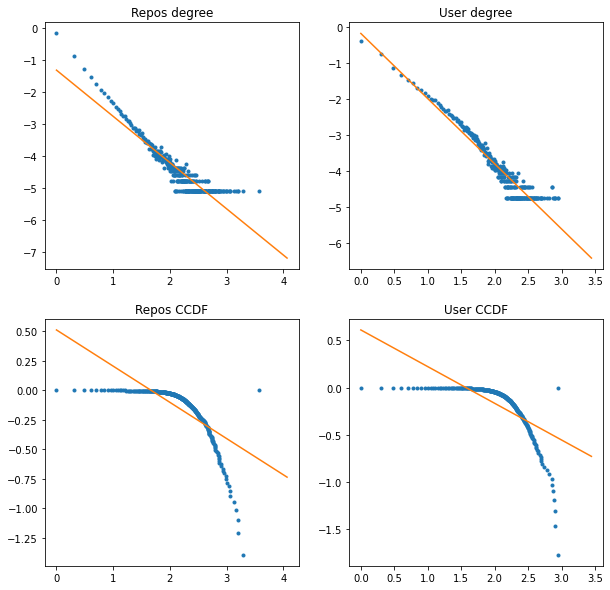

In [ ]:
#Power law fit


x_data = [repos_degree,user_degree,repos_degree,user_degree]
y_data = [count_repos_degree,count_user_degree,ccdf_repos_degree,ccdf_user_degree]
titles = ['Repos degree','User degree','Repos CCDF','User CCDF']

#Transforming the scale and checking for 0 (where log is not defined)
# 0 comes from the CCDF because there is a 0 probability that x will be larger than the absolutely largest 
# degree in the network

x_trans_data = [np.where(i != 0, np.log10(i), 0) for i in x_data]
y_trans_data = [np.where(i != 0, np.log10(i), 0) for i in y_data]


fig, axes = plt.subplots(2,2, figsize=(10, 10), facecolor='w', edgecolor='k')
axes = axes.ravel()

for i in range(4):
    x,y = x_trans_data[i].reshape((-1,1)), y_trans_data[i]

    model = LinearRegression()
    model = model.fit(x,y)

    xs = np.linspace(np.min(x),np.max(x)+0.5,100)

    ys = model.predict(xs.reshape((-1,1)))

    axes[i].plot(x,y,'.')
    axes[i].plot(xs,ys)
    axes[i].set_title(titles[i])
    

## #05 Projections

In [ ]:
# Get V2, i.e., set of nodes representing repositories in acending sorted order by id
repos = [node for node in G.nodes() if node[0] == 'r']
users = [node for node in G.nodes() if node[0] == 'u']

# Show the start
print(repos[:5])
print(users[:5])

['r1', 'r2', 'r3', 'r4', 'r5']
['u1', 'u2', 'u3', 'u4', 'u5']


In [ ]:
# Get adjacency matrix for our network --> returns sparse scipy matrix; rows are repos, column are users
G_adj = bipartite.matrix.biadjacency_matrix(G, row_order=repos)

# Get its transpose
G_adj_T = sp.sparse.csr_matrix.transpose(G_adj)

### `Simple weights`

- **general idea:** Given two repositories $u$ and $v$ and their set of neighbors $N_u$ and $N_v$, we connect the two repositories if the set $N_u \cap N_v$ is non-empty. In addition, we assign weight $W_{u, v}$ to the edge such that $W = |N_u \cap N_v|$. 

In [ ]:
users = [node for node in G.nodes() if node[0] == 'u']

In [ ]:
# weight functions
def simple_weight(G, u, v):
    n_u, n_v = set(G[u]), set(G[v])
    # len of set of intersection
    return len(n_u & n_v) 

def jaccard(G, u, v):
    n_u, n_v = set(G[u]), set(G[v])
    # normalise len of set of intersectin by union
    return len(n_u & n_v) / len(n_u | n_v)

def vectorised_projection(G, u, v, metric='simple_weight'):
    v_u = np.array([1 if user in set(G[u]) else 0 for user in users])
    v_v = np.array([1 if user in set(G[v]) else 0 for user in users])
    
    if metric == 'simple_weight':
        return np.sum((v_u + v_v) == 2)

    elif metric == 'euclidean':
        # sp.spatial.distance.euclidean(v_u, v_v)
        return np.sqrt(np.sum(np.power((v_u - v_v),2)))  

    elif metric == 'normalised_euclidean':
        return 1 / (vectorised_projection(G, u, v, metric='euclidean') + 1)

    elif metric == 'pearson':
        return sp.stats.stats.pearsonr(v_u, v_v)[0] + 1

    elif metric == 'cosine':
        return 1 - sp.spatial.distance.cosine(v_u, v_v)

    else:
        print("Please specify one of the following metrics: ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine'].")

    
def hyperbolic(G, u, v):
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node])) - 1) for node in common])
    
def probs(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[u]))) for node in common])

def heats(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[v]))) for node in common])

def hybrid(G, u, v):  
    common = set(G[u]) & set(G[v])
    return sum([1/(len(set(G[node]))*len(set(G[u]))*len(set(G[v]))) for node in common])


weight_functions = [simple_weight, jaccard, vectorised_projection, hyperbolic, probs, heats]
func_names = ["Simple weight", "Jaccard", "Vectorised projection", "Hyperbolic", "Probs", "Heats"]


# test cases
x = np.array([0, 0, 0, 0, 0, 0, 0, 1, 1, 1])
y = np.array([0, 0, 0, 0, 0, 1, 0, 0, 1, 1])

"""
print('simple_weight: ', np.sum((x + y) == 2))
print('euclidean: ', np.sqrt(np.sum(np.power((x - y),2))))
print('normalised euclidean: ', 1 / (np.sqrt(np.sum(np.power((x - y),2))) + 1))
print('cosine: ', 1 - sp.spatial.distance.cosine(x, y))
print('pearsn: ', sp.stats.stats.pearsonr(x, y)[0] + 1)
"""

u = 'r6'
v = 'r3'

for f, name in zip(weight_functions, func_names):
    if f == vectorised_projection:
        for metric in ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine']:
            print(f"{name} ({metric}): {f(G, u, v, metric=metric)}")
    else: 
        print(f"{name}: {f(G, u, v)}")

# weight_functions = [simple_weight, jaccard]

Simple weight: 46
Jaccard: 0.05644171779141104
Vectorised projection (simple_weight): 46
Vectorised projection (euclidean): 27.730849247724095
Vectorised projection (normalised_euclidean): 0.03480579329130742
Vectorised projection (pearson): 1.1141858547035441
Vectorised projection (cosine): 0.12009256824858372
Hyperbolic: 1.08084272830345
Probs: 0.0016342158724736654
Heats: 0.004378860478807645


In [ ]:
if COMPUTE_PROJECTIONS:
    weight_functions = [simple_weight, jaccard, vectorised_projection, hyperbolic, probs, heats]
    func_names = ["Simple weight", "Jaccard", "Vectorised projection", "Hyperbolic", "Probs", "Heats"]
    for f, name in zip(weight_functions, func_names):
        if f == vectorised_projection:
            for metric in ['simple_weight', 'euclidean', 'normalised_euclidean', 'pearson', 'cosine']:
                try:
                    projected = bipartite.generic_weighted_projected_graph(G, nodes=repos, weight_function=f(metric=metric))
                    nx.readwrite.gml.write_gml(projected, f"{PATH_TO['data']['projections']}/{name}_{metric}.gml")
                except Exception as e:
                    print(f"Function: {name}_{metric} - failed because:")
                    print(e)
                    print("-"*10)
        else: 
            try:
                projected = bipartite.generic_weighted_projected_graph(G, nodes=repos, weight_function=f)
                nx.readwrite.gml.write_gml(projected, f"{PATH_TO['data']['projections']}/{name}.gml")
            except Exception as e:
                print(f"Function: {name} - failed because")
                print(e)
                print("-"*10)

## Linear algebra & Random walks
This sections implements most important things from the lecture 2.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=58d54238-eda4-4682-9c9f-301f49ceb237' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>